# Creating a Self-Organizing Map for American Feline Habitat data
This notebook is an exploration of aggregated American Feline Habitat data. The data consists of temperature, precipitation, elevation and landcover data recorded at locations where American Feline specimens have been collected by a variety of Natural History collections. In this context, "American Felines" consist of the species puma concolor, leopardus pardalis, lynx canadensis and panthera onca.

This notebook also serves as an excersize to the author in getting familiar with the R Kohonen package.

In [1]:
suppressWarnings <- suppressPackageStartupMessages
suppressWarnings(require("RPostgreSQL"))

Warning message:
"package 'RPostgreSQL' was built under R version 3.4.4"

#### Making connection to local PostgreSQL database containing the data
(Done using the guidance of https://www.r-bloggers.com/getting-started-with-postgresql-in-r/)

In [2]:
#PostgreSQL driver
driver <- dbDriver("PostgreSQL")

#Connect to database
connection <- dbConnect(driver, dbname = "testdb",
                 host = "localhost", port = 5432,
                 user = "postgres", password = "idigbio123")

#Check that connection is valid & table exists
#dbExistsTable(connection, "feline_data")

#### Loading data from database into R and preparing it for training the SOM

In [3]:
#Get data from database
df = dbGetQuery(connection, "SELECT * FROM feline_data")

#Select subset from data: longitude and latitude
df_subset = df[, c(4,5)]

# Change the data frame with training data to a matrix, center and scale all variables to give them equal importance during
# the SOM training process. 
df_subset_matrix <- as.matrix(scale(df_subset))

## Begin Creation of SOM
(Done using the guidance of https://www.r-bloggers.com/self-organising-maps-for-customer-segmentation-using-r/)
Most of the code below has been copied and modified from Shane Lynn's code found in the article listed above.

In [4]:
suppressWarnings(require("kohonen"))

Warning message:
"package 'kohonen' was built under R version 3.4.4"

In [15]:
#Define Self-Organizing Map size (No. of nodes)
som_grid <- somgrid(xdim = 12, ydim=12, topo="hexagonal")

#Build Self-Organizing Map
#rlen is no. of iterations, alpha is learning rate
som_model <- som(df_subset_matrix, 
    grid=som_grid, 
    rlen=500, #Optimum number of iterations?
    alpha=c(0.05,0.01), 
    keep.data = TRUE
)

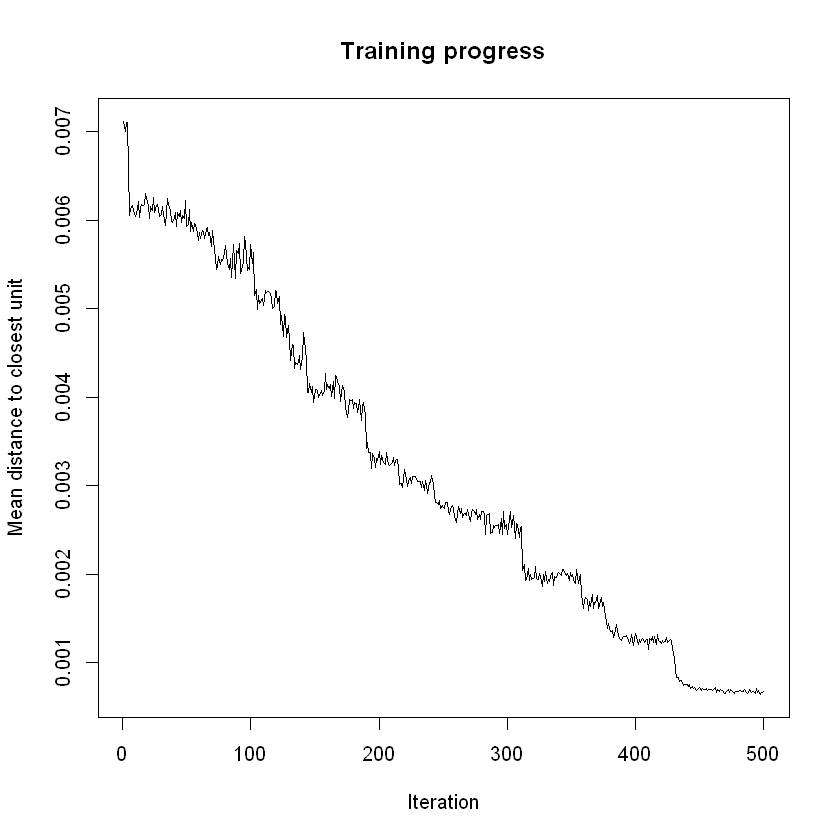

In [16]:
#Visualize training progress. According to Lynn should reach minimum plateau when no. of iterations sufficient
plot(som_model, type="changes")

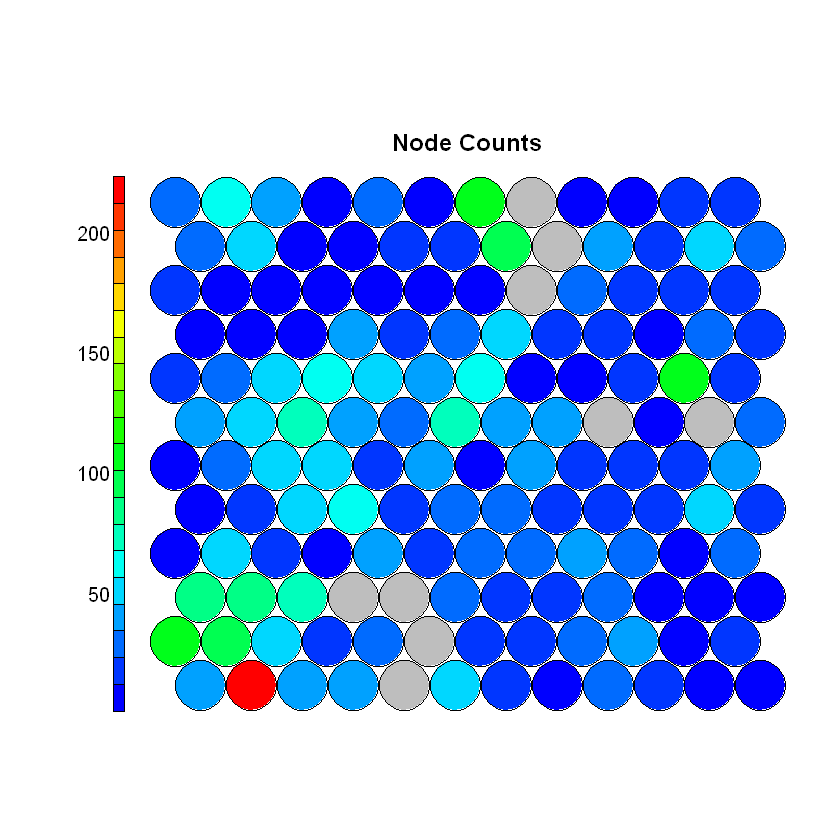

In [17]:
#Define color palette
coolBlueHotRed <- function(n, alpha = 1) {
  rainbow(n, end = 4/6, alpha = alpha)[n:1]
}

#Plot no. of vectors mapped to each node
plot(som_model, type = "count", main = "Node Counts", palette.name = coolBlueHotRed)

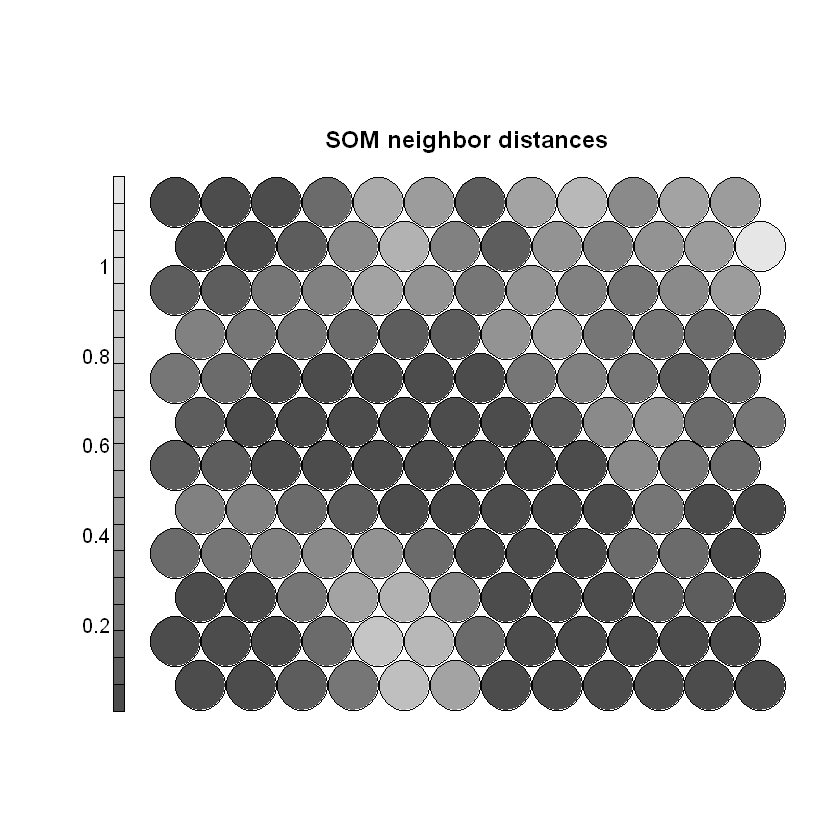

In [18]:
plot(som_model, type = "dist.neighbours", main = "SOM neighbor distances", palette.name = grey.colors)

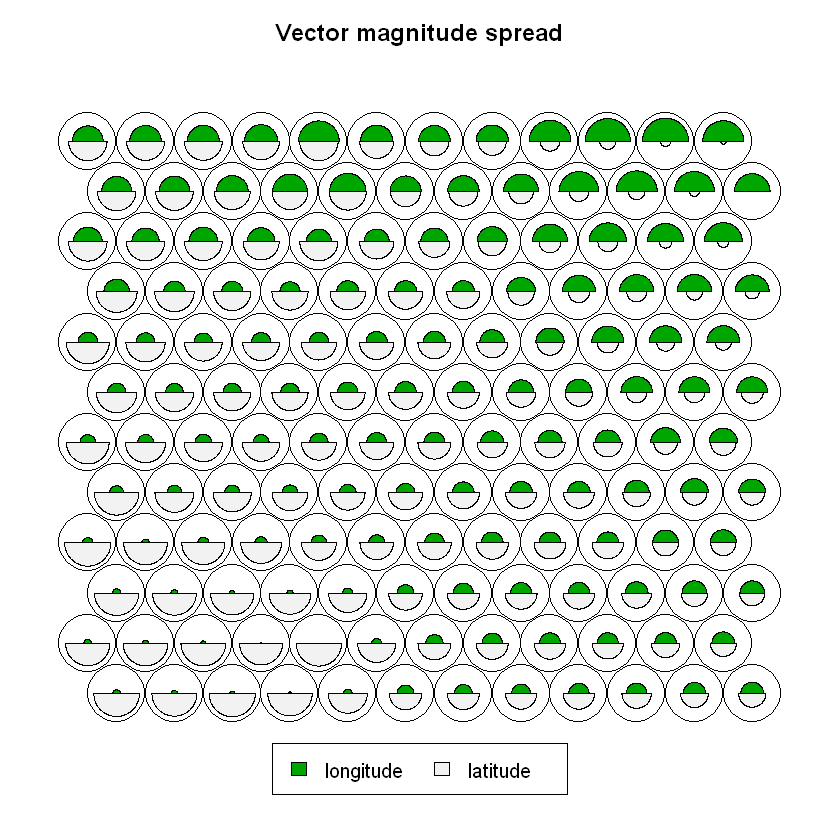

In [19]:
plot(som_model, type="codes", main = "Vector magnitude spread")

## Plotting heatmaps for each variable in dataset to visualize their mapping in the SOM model
Below, a heatmap for each variable's mapping in the data will be plotted to visualize their distribution.

Warning message in bgcolors[!is.na(showcolors)] <- bgcol[showcolors[!is.na(showcolors)]]:
"number of items to replace is not a multiple of replacement length"

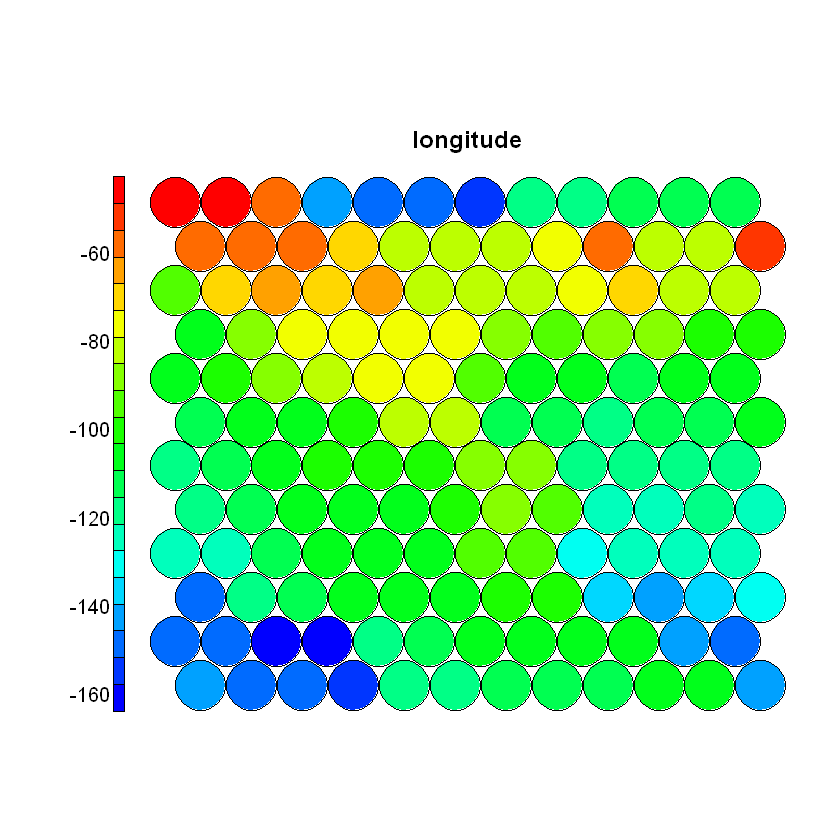

In [20]:
#Defining variable from dataset to plot, in this case longitude
var <- 1

#Scaling variable data back to original value
var_unscaled <- aggregate(as.numeric(df_subset[,var]), by=list(som_model$unit.classif), FUN=mean, simplify=TRUE)[,2]

#Plotting the heatmap
plot(som_model, type = "property", property=var_unscaled, main=names(df_subset)[var], palette.name=coolBlueHotRed)

Warning message in bgcolors[!is.na(showcolors)] <- bgcol[showcolors[!is.na(showcolors)]]:
"number of items to replace is not a multiple of replacement length"

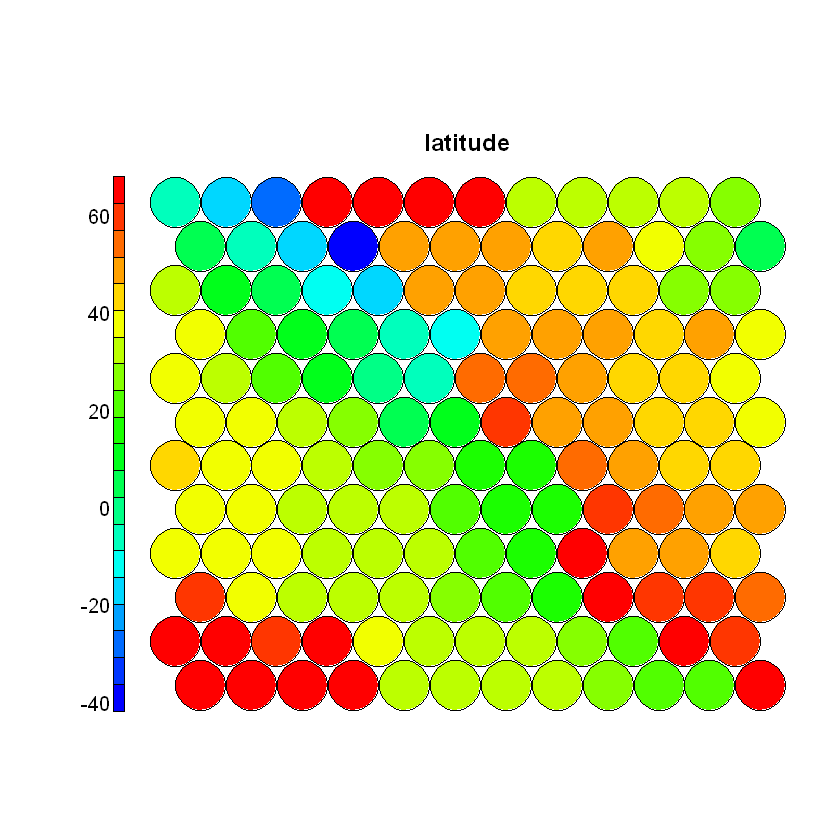

In [21]:
var <- 2 #Plotting dataset variable 2, latitude
var_unscaled <- aggregate(as.numeric(df_subset[,var]), by=list(som_model$unit.classif), FUN=mean, simplify=TRUE)[,2]
plot(som_model, type = "property", property=var_unscaled, main=names(df_subset)[var], palette.name=coolBlueHotRed)

### Cluster Analysis

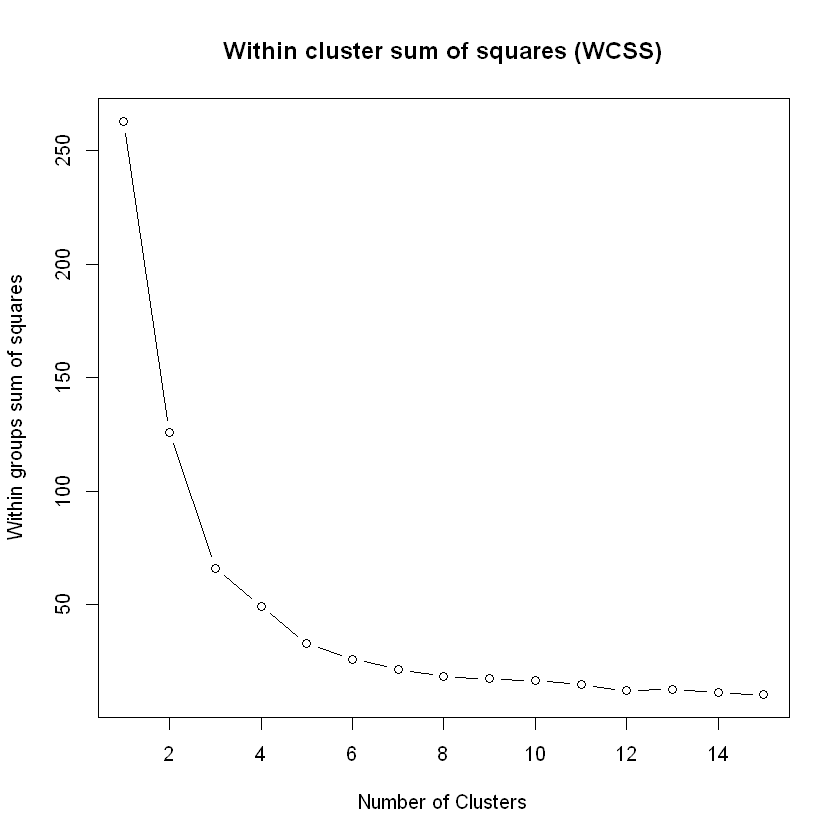

In [22]:
#Finding an estimate for no. of clusters using kmeans algortihm
mydata <- som_model$codes[[1]]
wss <- (nrow(mydata)-1)*sum(apply(mydata,2,var))

for (i in 2:15) {
  wss[i] <- sum(kmeans(mydata, centers=i)$withinss)
}

#Elbow point of plot indicates estimate of no. of clusters
plot(1:15, wss, type="b", xlab="Number of Clusters", ylab="Within groups sum of squares", main="Within cluster sum of squares (WCSS)")

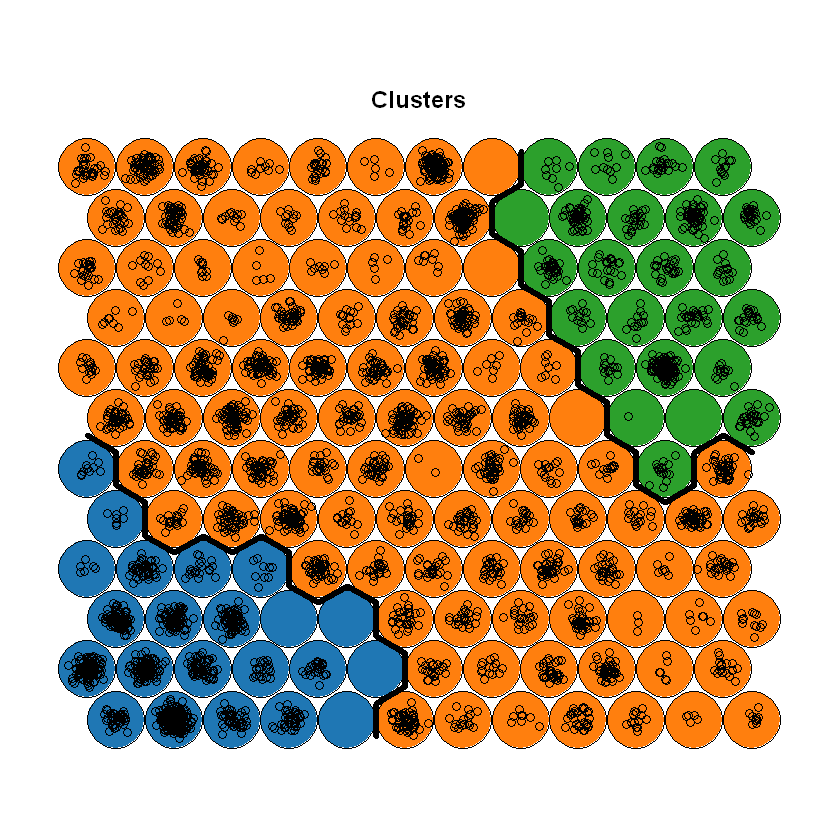

In [24]:
#Hierarchical clustering used to cluster the codebook vectors
som_cluster <- cutree(hclust(dist(som_model$codes[[1]])), 3)

#Defining palette colors
pretty_palette <- c("#1f77b4", '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b', '#e377c2')

#Plotting clusters
plot(som_model, type="mapping", bgcol = pretty_palette[som_cluster], main = "Clusters")
add.cluster.boundaries(som_model, som_cluster)

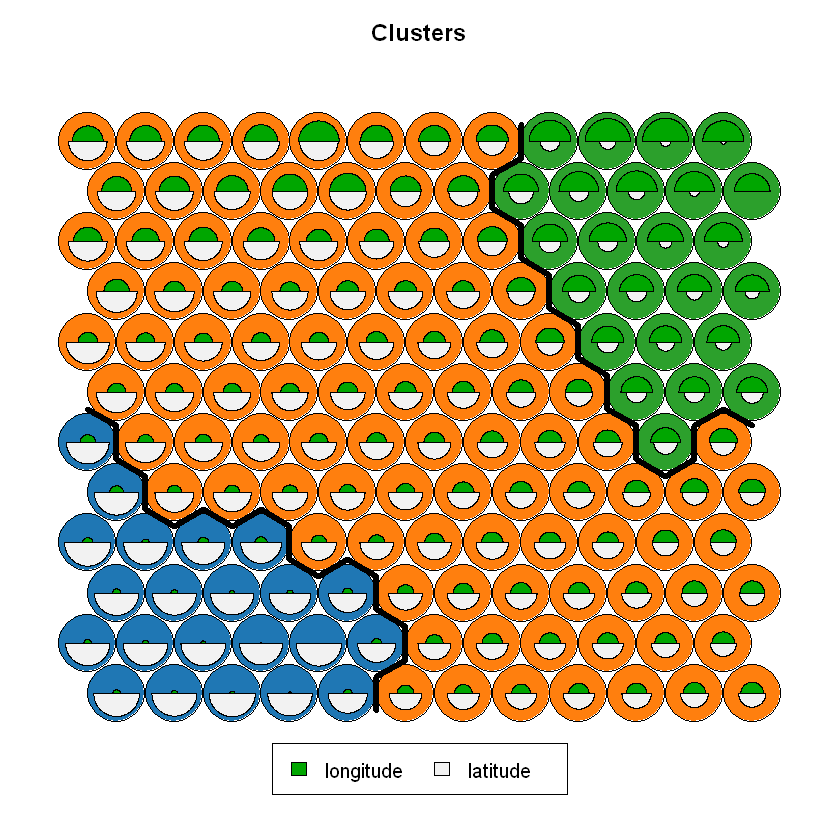

In [25]:
#show the same plot with the codes instead of just colours
plot(som_model, type="codes", bgcol = pretty_palette[som_cluster], main = "Clusters")
add.cluster.boundaries(som_model, som_cluster)